# Make Photoz test input from VIDEO SXDS data

This notebook uses the HELP python environment to make a eazy-pype input catalogue:

https://github.com/H-E-L-P/herschelhelp_internal

To make the photoz inputs we must merge in the spectroscopic redshifts and make some trivial catalogue changes. We then need to make configuration inputs for the photoz code. This includes downloading filter response curves.

Installation and running of the EAZY based code is described here:

https://github.com/dunkenj/eazy-pype/

This is an early test on the catalogues as part of our validation process.



In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g0b29ad24fb+cd38383676 	current w_2022_38 w_latest setup
obs_vista             23.0.0-1   	current setup


In [58]:

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
from herschelhelp.filters import correct_galactic_extinction
from herschelhelp.external import convert_table_for_cigale
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc, mag_to_flux

import numpy as np
import os
import time
from pathlib import Path

from astropy.time import Time
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

from collections import OrderedDict

In [3]:
#SUFFIX = os.environ.get('SUFFIX', time.strftime("%Y%m%d"))
SUFFIX=Time.now().isot.replace(':','').replace('-','')[:-4]

In [4]:
SUFFIX

'20230119T135958'

In [5]:
!mkdir figs

mkdir: figs: File exists


In [6]:
!ls ../../dmu5/dmu5_VIDEO/data/

3.0_startCoadd.slurm.e58711243
39
52
66
8523_5,2_reducedCat.fits
VSA_Ks_6.fits
calexp-HSC-R-8524-2,7.fits
calexp-VISTA-Y-8524-2,7.fits
copy_patches.sh
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoaddDetect_20220405T133706Z.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoaddDetect_20220720T183849Z.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoadd_20220411T145237Z.fits
example
full_reduced_cat_SXDS_20220802.fits
full_reduced_cat_SXDS_p2022.1_20220428.fits
full_reduced_cat_SXDS_p2022.1_20220721.fits.gz
highz_cands.fits
merged
u_ir-shir1_DRP_singleFrame_20220317T193549Z_2022-03-17_21:12.png
u_ir-shir1_DRP_videoCoadd_20220407T164547Z_2022-04-07_18:40.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-11_16:55.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-13_16:09.png
u_ir-shir1_DRP_videoMultiVisit3_20220420T134201Z_2022-04-20_14:49.png


In [7]:
#choose version
#version='p2021.1'
#infile ='../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS_p2021_1_20210702.fits'

version='p2022p3'
infile='../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS_20220802.fits'

# version='oxford'
# infile = "../../dmu3/data/XMMFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2020_06_01.fits"

hsc_bands = 'GRIZY'
vista_bands = 'ZYJHK'# removing ZY for now
bands = ['HSC_{}'.format(b) for b in hsc_bands]
bands += ['VIRCAM_{}'.format(b) for b in vista_bands]
    
if version.startswith('p202'):

    cols = ['id', 'VIRCAM_Ks_m_coord_ra','VIRCAM_Ks_m_coord_dec','VIRCAM_Ks_m_detect_isPrimary']
    cols+=['{}_m_base_CircularApertureFlux_6_0_flux'.format(b.replace('K','Ks')) for b in bands]
    cols+=['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(b.replace('K','Ks'))  for b in bands]
    cat = Table.read(infile)[cols]
    cat['ra']=cat['VIRCAM_Ks_m_coord_ra'] #.name='ra'
    cat['dec']=cat['VIRCAM_Ks_m_coord_dec'] #.name='dec'

    for c in cat.colnames:
        cat[c].name=c.replace('VISTA','VIRCAM')

In [8]:
if version=='oxford':
    imported_columns = OrderedDict({
            'ID_se':              'id', 
            'RA':     'ra', 
            'DEC':     'dec', 

            #'J_CLASS_STAR':    'vista_stellarity', 
            'flux_HSC-G':    'f_ap_hsc_g', 
            'err_HSC-G':     'ferr_ap_hsc_g',
            'flux_HSC-R':    'f_ap_hsc_r', 
            'err_HSC-R':     'ferr_ap_hsc_r',
            'flux_HSC-I':    'f_ap_hsc_i', 
            'err_HSC-I':     'ferr_ap_hsc_i',
            'flux_HSC-Z':    'f_ap_hsc_z', 
            'err_HSC-Z':     'ferr_ap_hsc_z',
            'flux_HSC-Y':    'f_ap_hsc_y', 
            'err_HSC-Y':     'ferr_ap_hsc_y',

            'flux_Z':    'f_ap_vircam_z', 
            'err_Z': 'ferr_ap_vircam_z', 

            'flux_Y':    'f_ap_vircam_y', 
            'err_Y': 'ferr_ap_vircam_y', 


            'flux_J':    'f_ap_vircam_j', 
            'err_J': 'ferr_ap_vircam_j', 


            'flux_H':    'f_ap_vircam_h', 
            'err_H': 'ferr_ap_vircam_h', 


            'flux_Ks':    'f_ap_vircam_ks', 
            'err_Ks': 'ferr_ap_vircam_ks', 


    })


    oxford_ks_cat = Table.read(infile
                          )[list(imported_columns)]


    for column in imported_columns:
        oxford_ks_cat[column].name = 'oxford_ks_' + imported_columns[column]



    oxford_ks_cat['oxford_ks_ra'].unit = u.deg
    oxford_ks_cat['oxford_ks_dec'].unit = u.deg
    oxford_ks_cat['oxford_ks_ra'].convert_unit_to(u.rad)
    oxford_ks_cat['oxford_ks_dec'].convert_unit_to(u.rad)
    oxford_ks_cat['ra'] = oxford_ks_cat['oxford_ks_ra']
    oxford_ks_cat['dec'] = oxford_ks_cat['oxford_ks_dec']
    print(len(oxford_ks_cat))

    for col in oxford_ks_cat.colnames:
        if col.startswith('oxford_ks_f_'):
            err_col = col.replace('_f_', '_ferr_')
            oxford_ks_cat[col].unit = u.erg/u.second/u.cm**2/u.Hz
            oxford_ks_cat[err_col].unit = u.erg/u.second/u.cm**2/u.Hz
            oxford_ks_cat[col].convert_unit_to(u.uJy)
            oxford_ks_cat[err_col].convert_unit_to(u.uJy)
            # m,merr = flux_to_mag(oxford_ks_cat[col]*1e-6,oxford_ks_cat[err_col]*1e-6) # expects Jansky
            # oxford_ks_cat[col.replace('_f_', '_m_')] = m
            # oxford_ks_cat[err_col.replace('_ferr_', '_merr_')] = merr
            # oxford_ks_cat.remove_columns([col,err_col])

    for col in oxford_ks_cat.colnames:
        if col.startswith('oxford_ks_f_ap_'):
            errcol=col.replace('_f_ap','_ferr_ap')
            mask = oxford_ks_cat[col]<-1e30
            oxford_ks_cat[col][mask] = np.nan
            oxford_ks_cat[errcol][mask] = np.nan

    for c in oxford_ks_cat.colnames:
        if c.startswith('oxford_ks_f_ap'):
            errcol=c.replace('_f_ap','_ferr_ap')
            oxford_ks_cat[c].convert_unit_to(u.nJy)
            oxford_ks_cat[errcol].convert_unit_to(u.nJy)
            physical_filter = c.split('_')[4].upper()+'_'+c.split('_')[5]
            physical_filter=physical_filter.upper()
            physical_filter=physical_filter.replace('KS','Ks')
            oxford_ks_cat[c].name='{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)
            oxford_ks_cat[errcol].name='{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(physical_filter)



    oxford_ks_cat['oxford_ks_id'].name='id'
    oxford_ks_cat['oxford_ks_ra'].name='VIRCAM_Ks_m_coord_ra'
    oxford_ks_cat['oxford_ks_dec'].name='VIRCAM_Ks_m_coord_dec'
    oxford_ks_cat['VIRCAM_Ks_m_detect_isPrimary']=np.full(len(oxford_ks_cat),1)
    cat=oxford_ks_cat

In [9]:
cat[:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_detect_isPrimary,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec
,deg,deg,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg
int64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
3036468485870845953,34.124187367393695,-5.112828142539714,0,45210.836,59014.73,nan,68704.69,nan,72939.1,70130.13,64893.312,55455.707,41048.035,8.253577,9.893899,nan,17.121132,nan,11.330954,18.064669,31.16792,50.41981,75.18533,34.124187367393695,-5.112828142539714
3036468485870845954,34.112782642747476,-5.117470227844656,0,199.6607,261.6193,nan,707.3632,nan,828.0095,973.7044,1157.9348,1030.825,1647.0935,4.4903297,6.707103,nan,15.140274,nan,11.875405,19.708263,31.594923,52.192463,78.655365,34.112782642747476,-5.117470227844656
3036468485870845955,34.10612947026398,-5.117562473234933,0,47.579445,59.21633,nan,49.955173,nan,131.30035,212.9792,127.644745,64.71357,-86.893974,4.412982,6.682137,nan,14.847394,nan,11.885592,18.632221,31.636147,52.251522,78.84118,34.10612947026398,-5.117562473234933
3036468485870845956,34.10477076807367,-5.117328910348277,0,206.84198,238.73009,nan,624.3138,nan,825.8898,999.8394,2011.4059,2736.6733,3858.044,4.4142413,6.472597,nan,14.79449,nan,11.903168,18.457453,31.694235,52.209904,78.75886,34.10477076807367,-5.117328910348277
3036468485870845957,34.093572968295405,-5.1167669040056385,0,24.610285,24.21981,nan,47.575,nan,250.89412,394.68927,406.48813,872.64136,115.65238,4.380789,6.4353576,nan,14.766015,nan,11.926036,20.178894,31.745302,52.34903,78.91348,34.093572968295405,-5.1167669040056385


In [10]:
#From email from Manda
oxfordApCorr = {
    'HSC_G_2as':0.1765,
    'HSC_G_3as':0.0788,
    'HSC_R_2as':0.1638,
    'HSC_R_3as':0.0905,
    'HSC_I_2as':0.1512,
    'HSC_I_3as':0.0788,
    'HSC_Z_2as':0.2155,
    'HSC_Z_3as':0.1144,
    'HSC_Y_2as':0.2023,
    'HSC_Y_3as':0.1144,
    'VIRCAM_Z_2as':0.3567,
    'VIRCAM_Z_3as':0.2023,
    'VIRCAM_Y_2as':0.3567,
    'VIRCAM_Y_3as':0.2023,
    'VIRCAM_J_2as':0.2980,
    'VIRCAM_J_3as':0.1765,
    'VIRCAM_H_2as':0.2423,
    'VIRCAM_H_3as':0.1512,
    'VIRCAM_Ks_2as':0.2288,
    'VIRCAM_Ks_3as':0.1388}

In [11]:
for c in cat.colnames:
    if c.endswith('_mag'):
        #print(c)
        physical_filter='{}_{}'.format(c.split('_')[0],c.split('_')[1])
        #print(np.nanmedian(test_cat[c]))
        #Following correction once to fix issue with calibrators and twice to apply apperture corrections!
        if version=='p2021.1':
            if 'HSC' in physical_filter:
                cat[c]-=1*oxfordApCorr['{}_2as'.format(physical_filter)]
            elif 'VIRCAM' in physical_filter:
                cat[c]-=2*oxfordApCorr['{}_2as'.format(physical_filter)]
        elif version=='p2022p3':
            cat[c]-=1*oxfordApCorr['{}_2as'.format(physical_filter)]
        #print(np.nanmedian(test_cat[c]))
        #cat[c.replace('mag','flux')],cat[c.replace('mag','fluxErr')]=mag_to_flux(
         #   cat[c],cat[c.replace('mag','magErr')])
        
    if c.endswith('_flux') or c.endswith('_fluxErr'):
        #print(c)
        physical_filter='{}_{}'.format(c.split('_')[0],c.split('_')[1])
        #print(np.nanmedian(test_cat[c]))
        #Following correction once to fix issue with calibrators and twice to apply apperture corrections!
        if version.startswith('p202'):
            if 'VIRCAM' in c:
                apCorr=(oxfordApCorr['{}_2as'.format(physical_filter)]
                        #These next two lines account for the fact that the calibrators were corrected by the 2 arcsec values for 3 arcsec measurements
                        +oxfordApCorr['{}_3as'.format(physical_filter)]
                        -oxfordApCorr['{}_2as'.format(physical_filter)])
                cat[c]*=10**(apCorr/2.5)
            if 'HSC' in c: #No aperture bug correction required in HSC
                apCorr=(oxfordApCorr['{}_2as'.format(physical_filter)])
                cat[c]*=10**(apCorr/2.5)

In [12]:
for c in cat.colnames:
    if  c.endswith('_fluxErr'):
        mask = np.abs(cat[c]/cat[c.replace('_fluxErr','_flux')])<0.05
        minerror=np.abs(0.05*cat[c.replace('_fluxErr','_flux')].copy())
        cat[c][mask]=minerror[mask]
        print(c,np.sum(mask),np.sum(np.abs(cat[c]/cat[c.replace('_fluxErr','_flux')])<0.049),np.sum(cat[c.replace('_fluxErr','_flux')]<0),len(cat))

HSC_G_m_base_CircularApertureFlux_6_0_fluxErr 1250387 0 99666 4739126
HSC_R_m_base_CircularApertureFlux_6_0_fluxErr 1201401 0 82677 4739126
HSC_I_m_base_CircularApertureFlux_6_0_fluxErr 1014597 0 66741 4739126
HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr 908491 0 94933 4739126
HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr 410436 0 331635 4739126
VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr 1044325 0 393784 4739126
VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr 1224667 0 579884 4739126
VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr 940829 0 581177 4739126
VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr 791646 0 651015 4739126
VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr 686804 0 678155 4739126


In [13]:
cat[cat['VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux']==0.0][:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_detect_isPrimary,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec
,deg,deg,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg
int64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
3122947274418683908,35.95785094790407,-4.003259630270109,0,nan,211.18672,187.29561,172.85991,136.78534,0.0,0.0,0.0,1069.691,0.0,nan,18.01378,21.316242,33.154804,108.91227,nan,nan,nan,71.81236,nan,35.95785094790407,-4.003259630270109
3122947274418683909,35.928099243621574,-4.003268327409578,0,nan,1200.8501,1554.5458,2222.8726,2356.3933,0.0,0.0,0.0,1069.7336,0.0,nan,60.042507,77.72729,111.14363,117.819664,nan,nan,nan,71.81236,nan,35.928099243621574,-4.003268327409578
3122947274418683910,35.925152133953475,-4.003269130353664,0,nan,6473.262,5481.3696,5147.5776,6064.706,0.0,0.0,0.0,1069.7344,0.0,nan,323.66312,274.06848,257.37888,303.23532,nan,nan,nan,71.81236,nan,35.925152133953475,-4.003269130353664
3122947274418683911,35.92323403276956,-4.0027096651471155,0,nan,2919.4478,3678.4155,4794.932,5205.238,0.0,0.0,0.0,1070.4412,0.0,nan,145.9724,183.92078,239.74661,260.2619,nan,nan,nan,71.81563,nan,35.92323403276956,-4.0027096651471155
3122947274418683912,35.9154219181522,-4.002991715197956,0,nan,95018.04,45218.035,228705.33,125052.734,0.0,0.0,0.0,1070.1646,0.0,nan,4750.902,2260.9019,11435.267,6252.6367,nan,nan,nan,71.815605,nan,35.9154219181522,-4.002991715197956


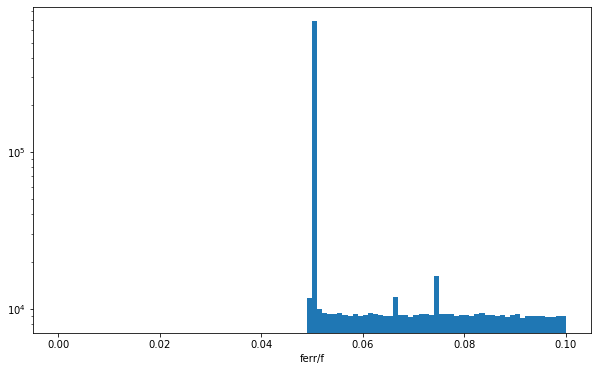

In [14]:
plt.hist(cat['VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr']/cat['VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux'],range=[0,0.1],bins=100)
plt.xlabel('ferr/f')
plt.yscale('log')

In [15]:
for b in bands:
    b=b.replace('VISTA','VIRCAM').replace('_K','_Ks')
    print(b)
    
    flux_col="{}_m_base_CircularApertureFlux_6_0_flux".format(b.replace('VISTA','VIRCAM'))
    err_col=flux_col+"Err"
    bad_meas=cat[flux_col]>1e10
    bad_meas|=cat[err_col]>1e10
    bad_meas|=cat[flux_col]<-1e10
    bad_meas|=cat[err_col]<-1e10
    print(np.sum(bad_meas),len(bad_meas))
    cat[flux_col][bad_meas]=np.nan
    cat[err_col][bad_meas]=np.nan
    
    #Try recalibrating errors
    if 'VIRCAM' in b:
        pass
        #cat[err_col]*=4

HSC_G
0 4739126
HSC_R
0 4739126
HSC_I
0 4739126
HSC_Z
0 4739126
HSC_Y
0 4739126
VIRCAM_Z
5 4739126
VIRCAM_Y
0 4739126
VIRCAM_J
0 4739126
VIRCAM_H
0 4739126
VIRCAM_Ks
0 4739126


In [16]:
# #Rename to CIGALE/HELP format
# for c in cat.colnames:
#     if c.endswith('m_base_CircularApertureFlux_6_0_flux'):
#         mask = cat[c]>1e10
#         cat[c][mask]=np.nan
#         f_name='{}_{}_flux'.format(
#             c.split('_')[0].lower(),#.replace('hsc','suprime'),
#             c.split('_')[1].lower()
#         )
#         cat[c].name=f_name
#         cat[f_name]=cat[f_name].to(u.uJy)
#     if c.endswith('m_base_CircularApertureFlux_6_0_fluxErr'):
#         mask = cat[c]>1e10
#         cat[c][mask]=np.nan
#         ferr_name='{}_{}_fluxerr'.format(
#             c.split('_')[0].lower(),#.replace('hsc','suprime'),
#             c.split('_')[1].lower()
#         )
#         cat[c].name=ferr_name
#         cat[ferr_name]=cat[ferr_name].to(u.uJy)

In [17]:
mask = (cat['ra']<1e10) | (cat['dec']<1e10)
mask&=cat['VIRCAM_Ks_m_detect_isPrimary']==1
#mask&=(cat['hsc_i_flux']/cat['hsc_i_fluxerr'] > 5)
#mask&=(cat['vista_ks_flux']/cat['vista_ks_fluxerr'] > 5)
cat = cat[mask]
    
cat['ra']=cat['ra'].to(u.deg)
cat['dec']=cat['dec'].to(u.deg)


In [18]:
#cat['zspec'].name='z_spec'

## Merge Specz

In [19]:
specz=Table.read('./data/XMM-LSS-specz-v2.91.fits.gz')
for c in specz.colnames:
    specz[c].name=c.lower()
specz['objid'].name='specz_id'

In [20]:
len(specz)

127682

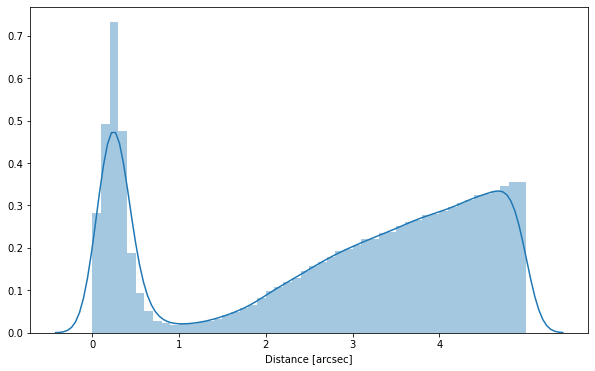

In [21]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'], cat['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [22]:
cat = specz_merge(cat, specz, radius=1. * u.arcsec)

In [23]:
#cat=cat[cat['specz_id']!='']
#cat['redshift']=cat['zspec']

In [24]:
#Replace nans with -99
cat['zspec'].name='z_spec'
cat['z_spec'][np.isnan(cat['z_spec'])]=-99

In [25]:
#remove spaces from specz id
cat['specz_id'] = [s.replace(' ','') for s in cat['specz_id']]

In [26]:
#add int id col
#cat['id']=np.arange(len(cat))

In [27]:
len(cat)

2466951

Text(0.5, 0, 'HSC-I snr')

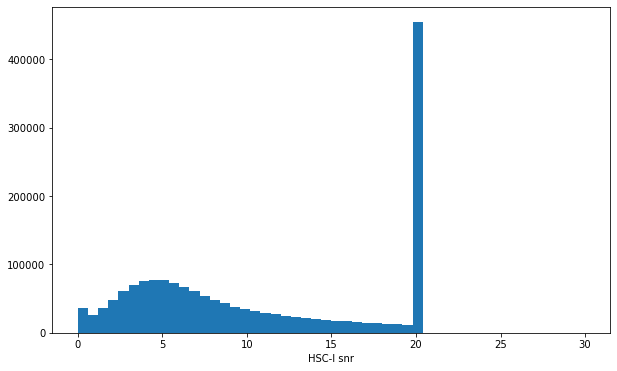

In [28]:
# hsc_i_flux,hsc_i_fluxerr=mag_to_flux(
#     cat['HSC_I_m_base_CircularApertureFlux_6_0_mag'],cat['HSC_I_m_base_CircularApertureFlux_6_0_magErr'])
hsc_i_flux,hsc_i_fluxerr=(
    cat['HSC_I_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_I_m_base_CircularApertureFlux_6_0_fluxErr'])
plt.hist(hsc_i_flux/hsc_i_fluxerr,bins=50,range=[0,30])
plt.xlabel('HSC-I snr')

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'log10(VIRCAM_Y)')

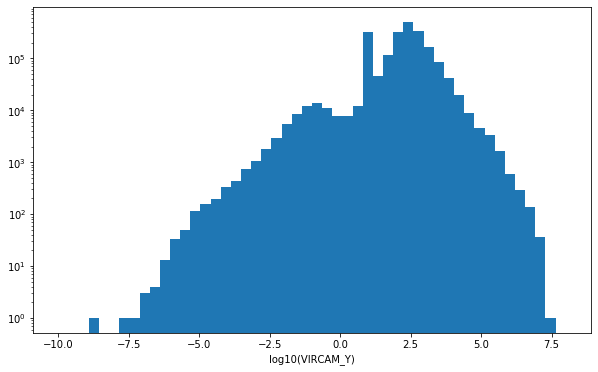

In [29]:
plt.hist(np.log10(cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux']),bins=50,range=[-10,8])
plt.yscale('log')
plt.xlabel('log10(VIRCAM_Y)')

In [30]:
np.sum(cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux']<0)

289413

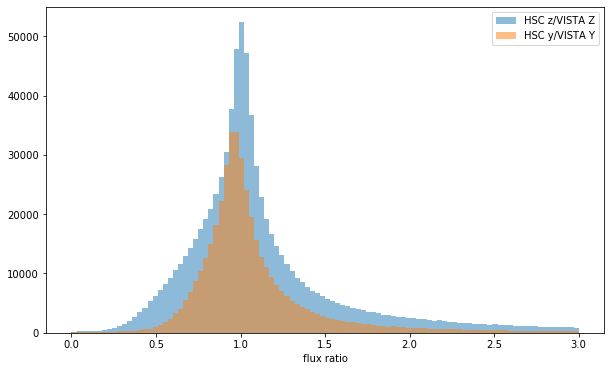

In [31]:
hsc_z_flux,hsc_z_fluxerr=(
    cat['HSC_Z_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr'])
vircam_z_flux,vircam_z_fluxerr=(
    cat['VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux'],cat['VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr'])
hsc_y_flux,hsc_y_fluxerr=(
    cat['HSC_Y_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr'])
vircam_y_flux,vircam_y_fluxerr=(
    cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux'],cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr'])
try:
    z_rat=hsc_z_flux/vircam_z_flux
    z_m=np.isfinite(z_rat) & (hsc_z_flux/hsc_z_fluxerr>5)
    y_rat=hsc_y_flux/vircam_y_flux
    y_m=np.isfinite(y_rat) & (hsc_y_flux/hsc_y_fluxerr>5)
    plt.hist(z_rat[z_m],bins=100,range=[0,3],alpha=0.5,label='HSC z/VISTA Z')
    plt.hist(y_rat[y_m],bins=100,range=[0,3],alpha=0.5,label='HSC y/VISTA Y')
    plt.xlabel('flux ratio')
    plt.legend()
    plt.savefig('./figs/flux_ratios_{}.png'.format(version))
except KeyError:
    print('No VISTA ZY bands')

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


Text(0.5, 0, 'log10(SNR)')

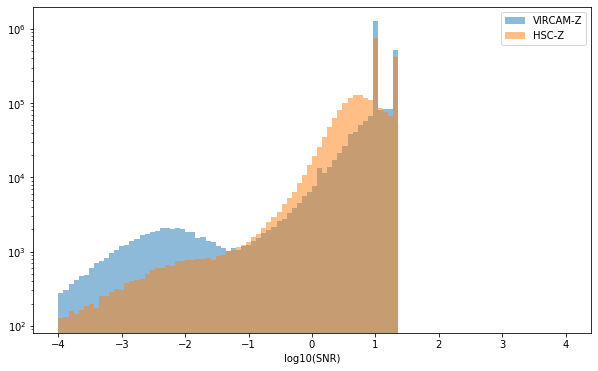

In [32]:
plt.hist(np.log10(vircam_z_flux/vircam_z_fluxerr),bins=100,alpha=0.5,label='VIRCAM-Z',range=[-4,4])
plt.hist(np.log10(hsc_z_flux/hsc_z_fluxerr),bins=100,alpha=0.5,label='HSC-Z',range=[-4,4])
plt.legend()
plt.yscale('log')
plt.xlabel('log10(SNR)')

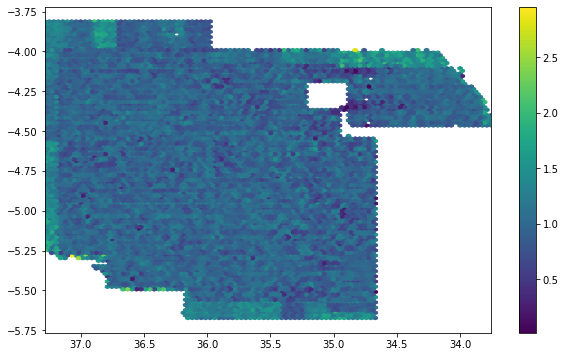

In [33]:
try:
    m=(y_rat>0) & (y_rat<3)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'],C=y_rat[m], gridsize=100)
    plt.colorbar()
    plt.xlim(np.nanmax(cat[m]['ra']),np.nanmin(cat[m]['ra']))
except NameError:
    print('No VISTA ZY bands')

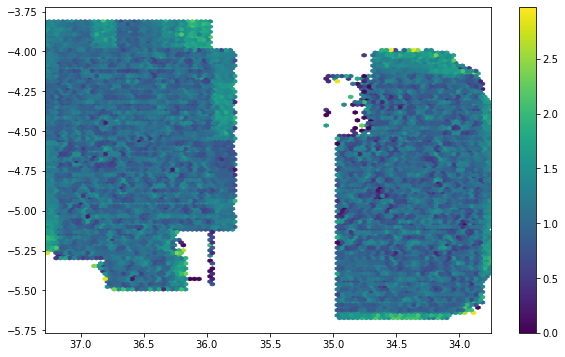

In [34]:
try:
    m=(z_rat>0) & (z_rat<3)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'],C=z_rat[m], gridsize=100)
    plt.colorbar()
    plt.xlim(np.nanmax(cat[m]['ra']),np.nanmin(cat[m]['ra']))
except NameError:
    print('No VISTA ZY bands')

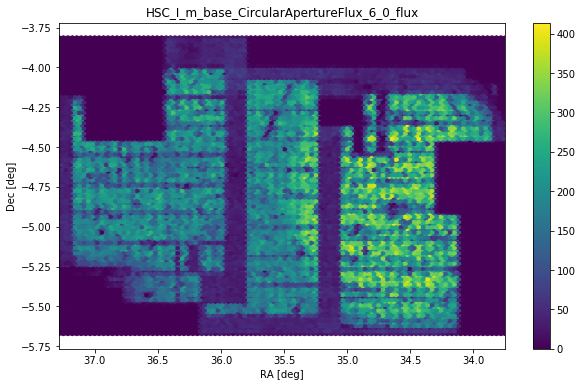

In [35]:
try:
    fluxCol='HSC_I_m_base_CircularApertureFlux_6_0_flux'
    m=(cat[fluxCol]/cat[fluxCol.replace('flux','fluxErr')]>5) #& (cat[fluxCol]<30)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'], gridsize=100)
    plt.colorbar()
    plt.title(fluxCol)
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.xlim(np.nanmax(cat[m]['ra']),np.nanmin(cat[m]['ra']))
except NameError:
    print('No data')

## Add EBV column

This is used to correct for galactic extinction.

In [36]:
cat.add_column(
    ebv(cat['ra'], cat['dec'])
)

## Write catalogue

In [37]:
cat[:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_detect_isPrimary,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,specz_id,z_spec,zspec_qual,zspec_association_flag,ebv
,deg,deg,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,,,
int64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,str25,float64,int64,bool,float64
3036468485870846118,34.116859550157464,-5.113130877627677,1,40.926807,54.322937,nan,78.63234,nan,46.186947,249.92984,91.6503,-685.7131,-49.268246,5.089149,7.3538694,nan,17.892424,nan,nan,nan,nan,nan,nan,34.116859550157464,-5.113130877627677,,-99.0,-99,False,0.019211495624006106
3036468485870846135,34.00439706836767,-5.1125861293942325,1,90.13256,127.69861,nan,233.85907,nan,96.16772,46.819252,167.97998,449.83655,602.7782,5.458248,7.8080306,nan,19.219131,nan,14.554512,23.046064,36.4044,59.833588,86.39378,34.00439706836767,-5.1125861293942325,,-99.0,-99,False,0.017543814826140293
3036468485870846144,34.10689001771839,-5.112357675424009,1,67.417046,62.366444,nan,71.16976,nan,146.25014,168.27908,289.51266,216.6295,365.65103,4.966421,7.2781134,nan,17.645796,nan,14.353352,22.581139,37.29492,60.122356,89.59054,34.10689001771839,-5.112357675424009,,-99.0,-99,False,0.019174222000565108
3036468485870846149,34.08977874881402,-5.11233286779129,1,32.083046,49.027245,nan,62.864662,nan,140.08275,225.45038,287.09872,13.713618,-26.620256,4.9667025,7.3326735,nan,17.750734,nan,14.399483,22.358152,37.47721,60.352364,89.93666,34.08977874881402,-5.11233286779129,,-99.0,-99,False,0.018907563885984465
3036468485870846152,34.02641913094855,-5.112035411116851,1,98.47988,85.468216,nan,78.35276,nan,-20.66493,64.42713,161.34328,519.1765,-220.84831,5.2032614,7.383944,nan,18.20245,nan,16.52951,24.479267,40.457054,64.75679,97.11449,34.02641913094855,-5.112035411116851,,-99.0,-99,False,0.01785986280124196


In [38]:
for c in cat.colnames:
    if c.endswith('flux'):
        m=np.array(~np.isfinite(cat[c]))
        m|=np.array(cat[c])>1e18
        cat[c][m]=np.nan
        cat[c+'Err'][m]=np.nan

In [39]:
cat[0:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_detect_isPrimary,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,specz_id,z_spec,zspec_qual,zspec_association_flag,ebv
,deg,deg,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,,,
int64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,str25,float64,int64,bool,float64
3036468485870846118,34.116859550157464,-5.113130877627677,1,40.926807,54.322937,nan,78.63234,nan,46.186947,249.92984,91.6503,-685.7131,-49.268246,5.089149,7.3538694,nan,17.892424,nan,nan,nan,nan,nan,nan,34.116859550157464,-5.113130877627677,,-99.0,-99,False,0.019211495624006106
3036468485870846135,34.00439706836767,-5.1125861293942325,1,90.13256,127.69861,nan,233.85907,nan,96.16772,46.819252,167.97998,449.83655,602.7782,5.458248,7.8080306,nan,19.219131,nan,14.554512,23.046064,36.4044,59.833588,86.39378,34.00439706836767,-5.1125861293942325,,-99.0,-99,False,0.017543814826140293
3036468485870846144,34.10689001771839,-5.112357675424009,1,67.417046,62.366444,nan,71.16976,nan,146.25014,168.27908,289.51266,216.6295,365.65103,4.966421,7.2781134,nan,17.645796,nan,14.353352,22.581139,37.29492,60.122356,89.59054,34.10689001771839,-5.112357675424009,,-99.0,-99,False,0.019174222000565108
3036468485870846149,34.08977874881402,-5.11233286779129,1,32.083046,49.027245,nan,62.864662,nan,140.08275,225.45038,287.09872,13.713618,-26.620256,4.9667025,7.3326735,nan,17.750734,nan,14.399483,22.358152,37.47721,60.352364,89.93666,34.08977874881402,-5.11233286779129,,-99.0,-99,False,0.018907563885984465
3036468485870846152,34.02641913094855,-5.112035411116851,1,98.47988,85.468216,nan,78.35276,nan,-20.66493,64.42713,161.34328,519.1765,-220.84831,5.2032614,7.383944,nan,18.20245,nan,16.52951,24.479267,40.457054,64.75679,97.11449,34.02641913094855,-5.112035411116851,,-99.0,-99,False,0.01785986280124196


In [40]:
np.sum(cat['zspec_qual']>0)

69281

In [41]:
np.sum(cat['zspec_qual']>=4 )/np.sum(cat['zspec_qual']>0)

0.2224996752356346

In [42]:
np.sum(cat['zspec_qual']>=3 )/np.sum(cat['zspec_qual']>0)

0.5514065905515221

In [43]:
SUFFIX

'20230119T135958'

In [44]:
# n='./data/lsst_ir_fusion_sxds_photoz_input_{}.fits'.format(SUFFIX)
# cat.write(n,overwrite=True)
# print(n)

In [45]:
len(cat),np.sum(cat['z_spec']>=0)

(2466951, 68117)

In [46]:
np.sum(np.isclose(
    cat['HSC_G_m_base_CircularApertureFlux_6_0_fluxErr'][cat['z_spec']>=0]/cat['HSC_G_m_base_CircularApertureFlux_6_0_flux'][cat['z_spec']>=0]
    ,0.05))

46531

In [47]:
np.sum(np.isnan(cat['HSC_G_m_base_CircularApertureFlux_6_0_flux'][cat['z_spec']>=0]))

19973

In [48]:
has_every_band=~np.isnan(cat['HSC_G_m_base_CircularApertureFlux_6_0_flux'])
for b in 'rizyJHK':
    if b.islower():
        has_every_band&=~np.isnan(cat['HSC_{}_m_base_CircularApertureFlux_6_0_flux'.format(b.upper())])
        print(b,np.sum(np.isnan(cat['HSC_{}_m_base_CircularApertureFlux_6_0_flux'.format(b.upper())])))
    else:
        has_every_band&=~np.isnan(cat['VIRCAM_{}_m_base_CircularApertureFlux_6_0_flux'.format(b.upper().replace('K','Ks'))])
        print(b,np.sum(np.isnan(cat['VIRCAM_{}_m_base_CircularApertureFlux_6_0_flux'.format(b.upper().replace('K','Ks'))])))

r 410445
i 749324
z 614664
y 860934
J 401547
H 401547
K 401547


In [49]:
len(cat),np.sum(has_every_band),np.sum((cat['z_spec']>=0)&has_every_band)

(2466951, 1113083, 24521)

In [50]:
random_choice=np.random.choice([True,False],len(cat),p=[100000/np.sum(has_every_band),1-100000/np.sum(has_every_band)])

In [51]:
np.sum(((cat['z_spec']>=0) | random_choice)&has_every_band)

122228

In [52]:
n='./data/lsst_ir_fusion_sxds_photoz_input_random_sample_{}_{}.fits'.format(version,SUFFIX)
print(n)
cat[((cat['z_spec']>=0) | random_choice)&has_every_band].write(n,overwrite=True)

./data/lsst_ir_fusion_sxds_photoz_input_random_sample_p2022p3_20230119T135958.fits


In [53]:
n='./data/lsst_ir_fusion_sxds_photoz_input_specz_sample_{}_{}.fits'.format(version,SUFFIX)
print(n)
cat[(cat['z_spec']>=0)&has_every_band].write(n,overwrite=True)


./data/lsst_ir_fusion_sxds_photoz_input_specz_sample_p2022p3_20230119T135958.fits


## Make Le Phare input and run LePHARE

We need to modify the units, write the file as ascii and add the context


In [99]:
cat[(cat['z_spec']>=0)&has_every_band][:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_detect_isPrimary,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,specz_id,z_spec,zspec_qual,zspec_association_flag,ebv
,deg,deg,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,,,
int64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,str25,float64,int64,bool,float64
3036371728847602313,34.81991658828074,-5.477805884765407,1,1893.877,3239.745,4043.3892,4717.1973,6072.3643,4830.544,5148.1084,5607.95,6103.776,6909.653,94.69385,161.98726,202.16946,235.85986,303.61823,241.5272,257.40543,280.39752,305.1888,345.48264,34.81991658828074,-5.477805884765407,VIPERS-114035618,0.4265,5,False,0.018060171087140996
3036371728847602495,34.750900051930145,-5.474145659653572,1,2124.7493,3289.0222,6668.2344,8913.715,10096.346,9049.578,10047.472,13022.324,13573.18,18612.818,106.237465,164.45111,333.4117,445.68576,504.8173,452.4789,502.3736,651.1162,678.659,930.6409,34.750900051930145,-5.474145659653572,PRIMUS0202-02309,0.84900147,3,False,0.018110606371959673
3036371728847602747,34.71535313286915,-5.469416354067494,1,536.4612,1465.6638,2150.182,2715.1658,3255.099,2638.8481,2903.6987,3163.8333,4058.2551,4808.307,26.82306,73.283195,107.509094,135.75829,162.75496,131.94241,145.18494,158.19167,202.91277,240.41536,34.71535313286915,-5.469416354067494,PRIMUS0123-00079,0.3946724,2,False,0.0179051382959968
3036371728847604080,34.859710908082796,-5.444301687920237,1,367.31516,961.50696,1427.2982,1874.4443,2228.9026,1953.5637,2313.46,2447.0312,2047.9565,3111.922,18.365759,48.075348,71.364914,93.72222,111.44513,nan,nan,nan,nan,nan,34.859710908082796,-5.444301687920237,PRIMUS0203-01145,0.21716338,2,False,0.018726794409862815
3036371728847604457,34.731980924258785,-5.437623404589132,1,1196.9875,3856.5652,6920.199,9777.605,12802.76,10179.721,12456.597,15857.159,19229.64,24928.096,59.849377,192.82826,346.00998,488.88028,640.138,508.98605,622.82983,792.858,961.48206,1246.4048,34.731980924258785,-5.437623404589132,PRIMUS0122-02288,0.4538359,2,False,0.017894683558943792


In [101]:
def cat_to_lephare_in(cat_name,write_loc,tract,patch):
    """Take an output patch and make a lephare input file"""
    #Open output cat
    in_cat=Table.read(cat_name)
    #
    
    #Merge the spec-z
    
    out_cat=Table()
    out_cat['Id']=in_cat['id']
    bands='grizyZYJHK'
    n=0
    context=np.full(len(out_cat),0)

    for b in bands:
        physical_filter='{}_{}'.format('VIRCAM' if b.isupper() else 'HSC',b.upper().replace('K','Ks'))
        #mag_col='{}_m_base_CircularApertureFlux_6_0_mag'.format(physical_filter)
        #magerr_col=mag_col+'Err'
        flux_col='{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)
        fluxerr_col=flux_col+'Err'
        lepharename=b #Do we need a different filter name for lephare
        try:
            #Convert to nano jansky and then *(10**-9)*(10**-23)
            #flux,fluxerr=mag_to_flux(in_cat[mag_col],in_cat[magerr_col])
            
            out_cat[physical_filter]=in_cat[flux_col]*(10**-9)*(10**-23)
            out_cat['d_'+physical_filter]=in_cat[fluxerr_col]*(10**-9)*(10**-23)
            #Aperture corrections
            out_cat[physical_filter]*=10**(1*oxfordApCorr['{}_2as'.format(physical_filter)]/2.5)
            out_cat['d_'+physical_filter]*=10**(1*oxfordApCorr['{}_2as'.format(physical_filter)]/2.5)
            mask = np.isnan(out_cat['d_'+physical_filter]) # | (out_cat['d_'+physical_filter]<1e-9) 
            context+=~np.isnan(out_cat['d_'+physical_filter])*2**n
            
            #replace nans with -99.9
            out_cat[physical_filter]=out_cat[physical_filter].astype('float64')
            out_cat['d_'+physical_filter]=out_cat['d_'+physical_filter].astype('float64')
            
            out_cat[physical_filter][mask]=-99.9
            out_cat['d_'+physical_filter][mask]=-99.9
            
            
            n+=1
        except KeyError:
            print('VISTA Error: band {} missing on tract {} and patch {}.'.format(b,tract,patch))
        
        
    out_cat['context']=context
    out_cat['z-spec']=in_cat['z_spec']#np.full(len(out_cat),-99.9)#np.nan)
    #Write the input catalogue
    Path('data/{}/{}'.format(tract,patch)).mkdir(
                    parents=True, exist_ok=True)
    out_cat.write(write_loc, format='ascii.commented_header',overwrite=True)
    return out_cat

test = cat_to_lephare_in(n,'./data/specz.in',1,1)

In [153]:
%%bash --out t
$LEPHAREDIR/bin/zphota \
    -c config/photoz.para \
    -CAT_IN ./data/specz.in \
    -CAT_OUT ./data/specz.out \
    -PARA_OUT config/output.para \
    -ZPHOTLIB VISTA_COSMOS_FREE,ALLSTAR_COSMOS,QSO_COSMOS \
    -ADD_EMLINES 0,100 \
    -AUTO_ADAPT YES \
    -Z_STEP 0.04,0,6

In [154]:
with open('./data/specz_output_{}.txt'.format(time.strftime("%Y%m%d")),'w+') as f:
    f.write(t)
f.close()

In [156]:
out=Table.read('./data/specz.out',format='ascii.commented_header',header_start=48,data_start=49,delimiter='\s')

In [157]:
out[:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_ML,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,PDZ_BEST,SCALE_BEST,NBAND_USED,SCALE_BEST_1,NBAND_USED_1,CONTEXT,ZSPEC,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,CONTEXT_1,ZSPEC_1
int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,int64,int64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,float64
3036371728847622010,0.5139,0.5007,0.5303,0.5127,32.0921,29,0,0.0,99.0,92.1965,10,92.1965,10,0,0.15808,-99.9,1000000000.0,-99,1.56,57.8486,10001,-71,3.55275,0,0.15808
3036371728847622071,0.635,0.5325,0.6863,0.6203,1.15564,27,3,0.25,99.0,176.213,10,176.213,10,0,0.60115,0.12,4.22773,26,0.08,3.45959,10008,-97,12.7029,0,0.60115
3036371728847622080,0.5576,0.5043,0.6372,0.5697,1.09793,17,0,0.0,99.0,284.815,10,284.815,10,0,0.53739,0.24,4.38646,26,0.2,3.05438,10008,-108,18.6928,0,0.53739
3036371728847622166,0.4567,0.437,0.473,0.4651,15.1836,26,0,0.15,99.0,33.4777,10,33.4777,10,0,1.1245,-99.9,1000000000.0,-99,1.92,36.1115,10001,-141,31.5971,0,1.1245
3036371728847622204,0.7552,0.7189,0.7867,0.7644,2.72192,6,0,0.0,99.0,255.921,10,255.921,10,0,0.7587,-99.9,1000000000.0,-99,1.2,9.41487,10006,-123,35.9139,0,0.7587


Text(0.5, 0, 'Photometric redshift')

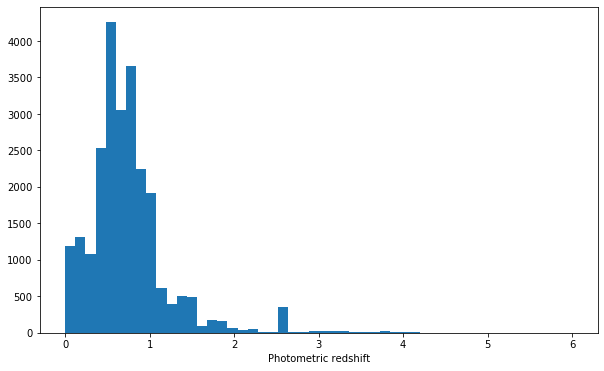

In [158]:
plt.hist(out['Z_BEST'],bins=50)
plt.xlabel('Photometric redshift')

Text(0.5, 0, 'Spectroscopic redshift')

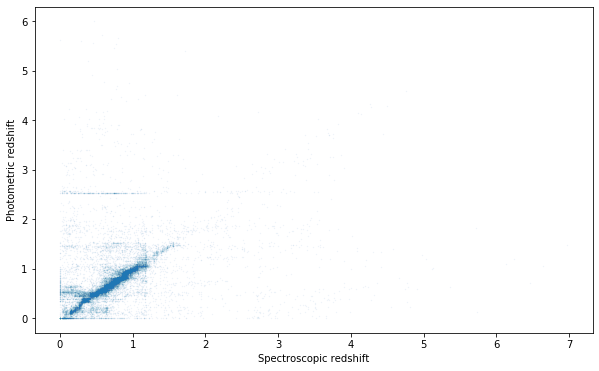

In [159]:
plt.scatter(out['ZSPEC'],out['Z_BEST'],s=0.1,alpha=0.1)
plt.ylabel('Photometric redshift')
plt.xlabel('Spectroscopic redshift')

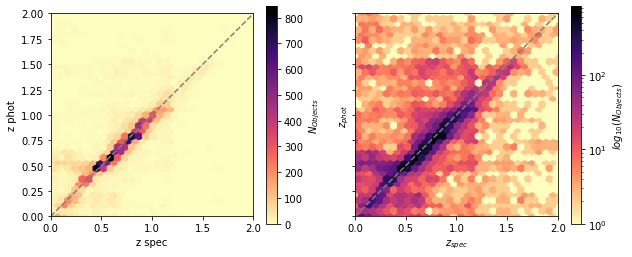

In [160]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=0,2
ylim=0,2

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')
                           
hb=ax0.hexbin(out['ZSPEC'],out['Z_BEST'],cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)
ax0.set_xlabel("z spec")
ax0.set_ylabel("z phot")
#ax0.set_title("z phot vs z spec")
ax0.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(out['ZSPEC'],out['Z_BEST'],bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("$z_{spec}$")
ax1.set_ylabel("$z_{phot}$")
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/photoz.png', bbox_inches='tight')

In [161]:
bins=np.linspace(0,6,100)
delz=(out['Z_BEST']-out['ZSPEC'])/(1+out['ZSPEC'])
delz_medians=[np.nanmedian(delz[(out['ZSPEC']>bins[n]) & (out['ZSPEC']<bins[n+1])]) for n in np.arange(len(bins[:-1]))]
delz_16s=[np.nanpercentile(delz[(out['ZSPEC']>bins[n]) & (out['ZSPEC']<bins[n+1])],16) for n in np.arange(len(bins[:-1]))]
delz_84s=[np.nanpercentile(delz[(out['ZSPEC']>bins[n]) & (out['ZSPEC']<bins[n+1])],84) for n in np.arange(len(bins[:-1]))]


/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


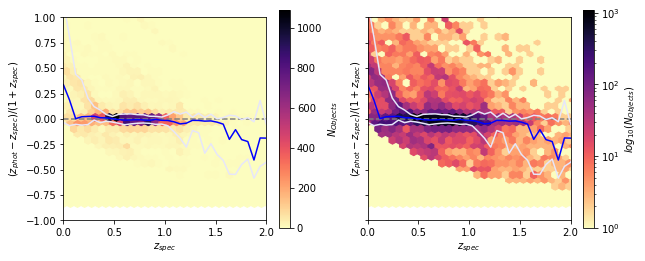

In [165]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=[0,2]
ylim=[-1,1]

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')
                           
hb=ax0.hexbin(out['ZSPEC'],(out['Z_BEST']-out['ZSPEC'])/(1+out['ZSPEC']),cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)
ax0.set_xlabel("$z_{spec}$")
ax0.set_ylabel("$(z_{phot}-z_{spec})/(1+z_{spec})$")
#ax0.set_title("Delta z vs z spec")
ax0.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax0.plot(bins[:-1],delz_medians,color='blue')
ax0.plot(bins[:-1],delz_16s,color='lavender')
ax0.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(out['ZSPEC'],(out['Z_BEST']-out['ZSPEC'])/(1+out['ZSPEC']),bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("$z_{spec}$")
ax1.set_ylabel("$(z_{phot}-z_{spec})/(1+z_{spec})$")
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax1.plot(bins[:-1],delz_medians,color='blue')
ax1.plot(bins[:-1],delz_16s,color='lavender')
ax1.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/delz.png', bbox_inches='tight')

Text(0.5, 0, 'Chi squared')

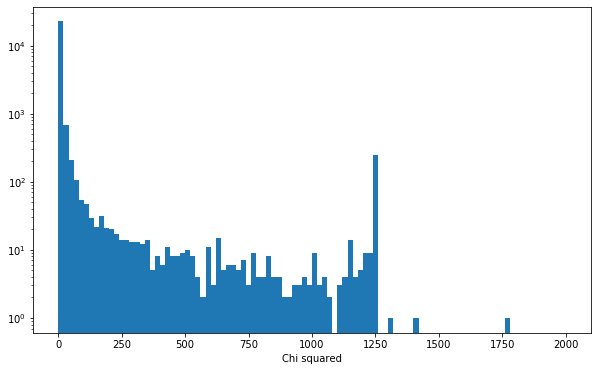

In [163]:
plt.hist(out['CHI_BEST'],bins=100,range=[0,2000])
plt.yscale('log')
plt.xlabel('Chi squared')